# FRB optical counterpart simulation

This notebook breaks down the simulation of a Fast Radio Bursts (FRB) optical counterpart in the Vera C. Rubin Observatory system. It starts with a simulation of a point-source star and an FRB. The photons are simulated through the atmosphere and the telescope system using Batoid and GalSim packages.

Import relevant python packages:

In [1]:
import pickle
import galsim
import batoid
import numpy as np
import matplotlib.pyplot as plt

Generate random number

In [2]:
rng = galsim.BaseDeviate(117)

## 1. Initialization of variables

Set initial variables and constants for the simulation.

In [3]:
# Some settings here.
SEEING_FACTOR = 1.0  # Knob to dial seeing up or down
PIXEL_SIZE = 10e-6
STAMP_SIZE = 10
SKY_LEVEL = 1000.0
DEFOCUS = 0.0015
M2_ALIGNMENT = 1.0
CAMERA_ALIGNMENT = 1.0
M1M3_BEND = 1.0
M2_BEND = 1.0
SHOW = True
SAVE_PHOTONS = False
NPHOTON = int(8e6)
NSTAR = 1
SIMPLIFY = False

# Define wavelength dictionary
wavelength_dict = dict(
    u = 365.49,
    g = 480.03,
    r = 622.20,
    i = 754.06,
    z = 868.21,
    y = 991.66
)

# Define the observation parameters.
observation = {
    'boresight': galsim.CelestialCoord(
        30*galsim.degrees, 10*galsim.degrees
    ),
    'zenith': 30*galsim.degrees,
    'airmass': 1.1547,
    'rotTelPos': 0.0*galsim.degrees,  # zenith measured CCW from up
    'rotSkyPos': 0.0*galsim.degrees,  # N measured CCW from up
    'rawSeeing': 0.7*galsim.arcsec,
    'band': 'i',
    'exptime': 15.0,
    'frbtime': 0.005,
    'temperature': 293.15,  # K
    'pressure': 69.328,  # kPa
    'H2O_pressure': 1.067,  # kPa
}

# Set the wavelenght from the observation band. 
wavelength = wavelength_dict[observation['band']]

# Load atmosphere phase screen list created from Elleboerk model.
with open("atm.pkl", 'rb') as f:
    atm = pickle.load(f)

## 1.2 Intitalize PSFs of FRB and point-source

In [18]:
# Define FRB as a delta function profile.
frb_delta = galsim.DeltaFunction(flux = 2e5)

# Shoot photons.
frb_photons = frb_delta.shoot(int(2e5), rng)

In [54]:
# Define point-source as a delta function profile
star_delta = galsim.DeltaFunction(flux = 2e5)

# Generate atmospheric PSF for a 15s expsoure. Includes first_kick and second_kick.
atm_psf = atm.makePSF(
            wavelength, 
            diam = 8.36, 
            time_step = 0.005, 
            exptime = 15.0, 
            flux = 1.0
        )

# Convolve with point-source psf
star_total_psf = galsim.Convolve([star_delta, atm_psf.second_kick])

# Shoot photons through star and atmsosphere second kick.
star_photons = star_total_psf.shoot(int(1e6), rng)

### 2.3 Simulated atmospheric images

Given the computed PSF above, in this section we generate corresponding images of the light traced through the atmosphere. The two initial figures are the point-source star and FRB on their own.

Trace photons through telescope for the frb or the star

In [55]:
phot_num_frb = frb_photons.x.shape[0]
phot_num_star = star_photons.x.shape[0]

# Change these two lines to select FRB or point-source to be imaged. 
# You also need to change the wavelength cell.
phot_num_tot =  phot_num_star
tot_photons = star_photons
first_kick = True

## 3. Telescope tracing

In this section we trace the photons through the telescope up until the detector, thus simulating the final image we would retrieve, were we to observe the simulated galaxy. We obtain an image with the FRB and an image fort the point-source star. 

### 3.0 Initialize telescope

Initialize in focus telescope from .yml document

In [56]:
# Initialize telescope 
telescope = batoid.Optic.fromYaml("LSST_r.yml")

### 3.1 Photons initial position

To trace the photons throught the telescope, we first need to determine the phtotons intial position in the first mirror. We do so by sampling the annular pupil uniformally. 

In [57]:
# Develop gnomonic projection from ra/dec to field angle using
# GalSim TanWCS class.
q = observation['rotTelPos'] - observation['rotSkyPos']
cq, sq = np.cos(q), np.sin(q)
affine = galsim.AffineTransform(cq, -sq, sq, cq)

# Generate field angles
radecToField = galsim.TanWCS(
                    affine,
                    observation['boresight'],
                    units = galsim.radians
                )

# Generate celestial coordinates
dist = 100*galsim.degrees
while (dist > 1.75*galsim.degrees):   # whole focal plane
    ra = np.random.uniform(26.0, 34.0)
    dec = np.random.uniform(7.0, 13.0)
    coord = galsim.CelestialCoord(
        ra*galsim.degrees, dec*galsim.degrees
    )
    dist = observation['boresight'].distanceTo(coord)
    
fieldAngle = radecToField.toImage(coord)

# Populate pupil
r_outer = 8.36/2

# purposely underestimate inner radius a bit.
# Rays that miss will be marked vignetted.
r_inner = 8.36/2*0.58
ud = galsim.UniformDeviate(rng)
r = np.empty(phot_num_tot)
ud.generate(r)
r *= (r_outer**2 - r_inner**2)
r += r_inner**2
r = np.sqrt(r)

# Sample angle around the pupil.
th = np.zeros(phot_num_tot)
ud.generate(th)
th *= 2*np.pi

# Assign pupil position given radius and theta.
u = r*np.cos(th)
v = r*np.sin(th)

### 3.2 Time stamp

Additionally, we also need to generate the time associated with each photon to simulate for the 15s exposure, in the case of the point-source star. We do so by randomly selecting a time for each photon. This is just used for Point-source (first-kick = true)

In [58]:
if first_kick == True:
    # Generate time vector for all photons.
    t = np.zeros(phot_num_tot)

    # Uniformly distribute galaxy photon times throughout 15s exposure
    ud.generate(t)
    t += observation['exptime']
    
else:
    t = observation['frbtime']

### 3.3 Wavelengths

In this section we define the SED for the galaxy and for the FRB, respectively. We then assing wavelengths to all photons sampling from their corresponding SED. 

In [63]:
# Define the black body SED. 
def BBSED(T):
    """
    (unnormalized) Blackbody SED for temperature T in Kelvin. 
    Generates SED of a star.
    """

    # Define wavelength vector
    waves_nm = np.arange(330.0, 1120.0, 10.0)

    # Compute Blackbody flux given temperature and wavelength.
    def planck(t, w):
        # T := temperature in K
        # w := wavelength in m
        c = 2.99792458e8  # speed of light in m/s
        kB = 1.3806488e-23  # Boltzmann's constant J per Kelvin
        h = 6.62607015e-34  # Planck's constant in J s
        return w**(-5) / (np.exp(h*c/(w*kB*t))-1)

    flambda = planck(T, waves_nm*1e-9)
    
    return galsim.SED(
        galsim.LookupTable(waves_nm, flambda),
        wave_type='nm',
        flux_type='flambda'
    )

# Define bandpass
bandpass = galsim.Bandpass('LSST_{}.dat'.format(observation['band']), wave_type='nm')

# Initialize the used galaxy SED and Temperature of the galaxy.
T_star = np.random.uniform(4000, 10000)
star_sed = BBSED(T_star)

# Assign wavelengths to all photons sampling the SED distribution.
star_wavelengths = star_sed.sampleWavelength(phot_num_star, bandpass, rng)

# Initialize the used FRB SED and Temperature of the FRB.
T_sed = np.random.uniform(4000, 10000)
frb_sed = BBSED(T_sed)

# Assign wavelengths to all photons sampling the SED distribution.
frb_wavelengths = frb_sed.sampleWavelength(phot_num_frb, bandpass, rng)

# ---- ATTENTION -----
#
# Change if studying FRB
#
# ---- ATTENTION -----
# Generate vector with all photons wavelenghts

wavelengths = star_wavelengths

### 3.3 Phase gradient

In [64]:
dku = np.zeros(phot_num_tot)
dkv = np.zeros(phot_num_tot)

# Implement first kick.
# Evaluate phase gradients at appropriate location/time
dku, dkv = atm.wavefront_gradient(
    u, v, t, (fieldAngle.x*galsim.radians, fieldAngle.y*galsim.radians)
)  

# Since the output is in nm per m, convert to radians.
dku *= 1e-9 
dkv *= 1e-9


# Add photons position from atmosphere to the phase gradients.
dku += tot_photons.x*(galsim.arcsec/galsim.radians)
dkv += tot_photons.y*(galsim.arcsec/galsim.radians)

dku *= (wavelengths/500)**(-0.3)
dkv *= (wavelengths/500)**(-0.3)


# DCR.  dkv is aligned along meridian, so only need to shift in this
# direction
# Compute refraction due to observation wavelength.
# This is also applies to FRB
base_refraction = galsim.dcr.get_refraction(
    wavelength,
    observation['zenith'],
    temperature = observation['temperature'],
    pressure = observation['pressure'],
    H2O_pressure = observation['H2O_pressure'],
)

# Compute refraction due to wavelenght for each photon.
refraction = galsim.dcr.get_refraction(
    wavelengths,
    observation['zenith'],
    temperature = observation['temperature'],
    pressure = observation['pressure'],
    H2O_pressure = observation['H2O_pressure'],
)

# Add the refraction difference to the phase gradient.
refraction -= base_refraction
dkv += refraction

# Add the tangent plane coordinates to the refraction difference.
dku += fieldAngle.x
dkv += fieldAngle.y

### Generate Batoid RayVector

In this section we generate a Batoid compatible rays vector that encodes the rays traced through the atmosphere. To do so we make use of the phase gradients, the pupil positions and the wavelengths.

In [65]:
# Generate rays velocity components from atmospheric phase gradient computed in the previous section.
vx, vy, vz = batoid.utils.fieldToDirCos(dku, dkv, projection='gnomonic')

# Place rays on entrance pupil - the planar cap coincident with the rim
# of M1.  Eventually may want to back rays up further so that they can
# be obstructed by struts, e.g.
x = u
y = v
zPupil = telescope["M1"].surface.sag(0, 0.5*telescope.pupilSize)
z = np.zeros_like(x) + zPupil

# Rescale velocities so that they're consistent with the current
# refractive index.
n = []
for idx in range(phot_num_tot):
    n.append(telescope.inMedium.getN(wavelengths[idx]))

vx /= n
vy /= n
vz /= n

# Adapt wavelength units.
wavelengths_arr = wavelengths*1e-9

In [66]:
# Create Batoid Ray Vector.
rays = batoid.RayVector.fromArrays(
    x.tolist(), y.tolist(), z.tolist(),
    vx.tolist(), vy.tolist(), vz.tolist(),
    np.zeros(phot_num_tot),
    wavelengths_arr.tolist(),
    np.zeros(phot_num_tot) + 1.0
)

### Trace through telescope and sensor

In this section we initialize the telescope and silicon sensor from the dispersion data file. Once initialzied, we trace the rays through the telescope and then we refract them through the sensor. 

In [67]:
# Trace rays through telescope
traced_rays = telescope.trace(rays)

In [68]:
# Initialize Silicon detector
w, n = np.genfromtxt("silicon_dispersion.txt").T
silicon = batoid.TableMedium(batoid.Table(w, n, 'linear'))
        
# Refract the output beam into the silicon detector.
telescope['Detector'].surface.refract(
    traced_rays,
    telescope['Detector'].inMedium,
    silicon
)

# Print number of non-vignetted rays.
print('Number of non-vingetted rays is {}'.format(sum(i for i in ~traced_rays.vignetted)))

Number of non-vingetted rays is 904210


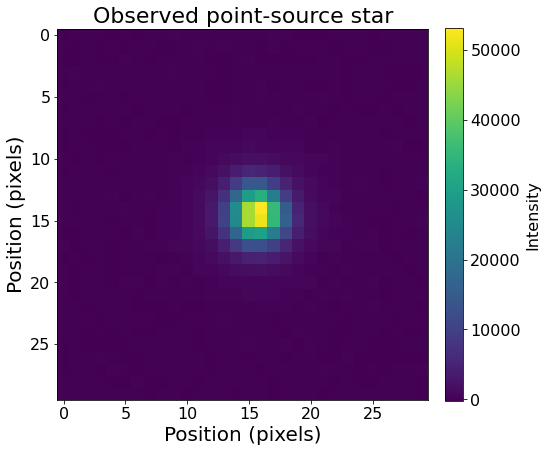

In [69]:
# Convert rays to pixels for galsim sensor object. Put batoid results back into photons.
tot_photons.x = traced_rays.x/PIXEL_SIZE
tot_photons.y = traced_rays.y/PIXEL_SIZE
tot_photons.dxdz = traced_rays.vx
tot_photons.dydz = traced_rays.vy
tot_photons.wavelength = wavelengths
tot_photons.flux = ~traced_rays.vignetted

# Initialize image
STAMP_SIZE_ = 30
final_image = galsim.Image(STAMP_SIZE_, STAMP_SIZE_)

# Set image center at the center of the photons
final_image.setCenter(
    int(np.mean(tot_photons.x[~traced_rays.vignetted])),
    int(np.mean(tot_photons.y[~traced_rays.vignetted]))
)

# Add photons to the image
sensor = galsim.Sensor()
#sensor = galsim.SiliconSensor(nrecalc=10_000)
sensor.accumulate(tot_photons, final_image)

# Add Gaussian background.
gd = galsim.GaussianDeviate(rng, sigma = np.sqrt(10_000))
gd.add_generate(final_image.array)

# Plot figure
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.imshow(final_image.array)
plt.title('Observed point-source star', fontsize = 22)
plt.xlabel('Position (pixels)', fontsize = 20)
plt.ylabel('Position (pixels)', fontsize = 20)
plt.tick_params(labelsize = 16)
cbar = plt.colorbar(fraction = 0.046, pad = 0.04, label = 'Intensity')
cbar.ax.tick_params(labelsize = 16)
cbar.ax.yaxis.label.set_size(16)

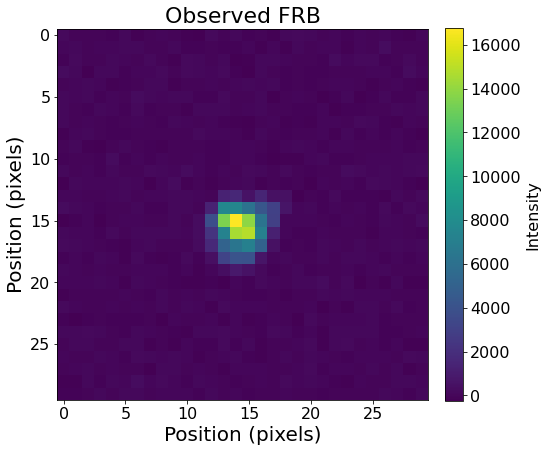

In [39]:
# Convert rays to pixels for galsim sensor object. Put batoid results back into photons.
tot_photons.x = traced_rays.x/PIXEL_SIZE
tot_photons.y = traced_rays.y/PIXEL_SIZE
tot_photons.dxdz = traced_rays.vx
tot_photons.dydz = traced_rays.vy
tot_photons.wavelength = wavelengths
tot_photons.flux = ~traced_rays.vignetted

# Initialize image
STAMP_SIZE_ = 30
final_image = galsim.Image(STAMP_SIZE_, STAMP_SIZE_)

# Set image center at the center of the photons
final_image.setCenter(
    int(np.mean(tot_photons.x[~traced_rays.vignetted])),
    int(np.mean(tot_photons.y[~traced_rays.vignetted]))
)

# Add photons to the image
sensor = galsim.Sensor()
#sensor = galsim.SiliconSensor(nrecalc=10_000)
sensor.accumulate(tot_photons, final_image)

# Add Gaussian background.
gd = galsim.GaussianDeviate(rng, sigma = np.sqrt(10_000))
gd.add_generate(final_image.array)

# Plot figure
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.imshow(final_image.array)
plt.title('Observed FRB', fontsize = 22)
plt.xlabel('Position (pixels)', fontsize = 20)
plt.ylabel('Position (pixels)', fontsize = 20)
plt.tick_params(labelsize = 16)
cbar = plt.colorbar(fraction = 0.046, pad = 0.04, label = 'Intensity')
cbar.ax.tick_params(labelsize = 16)
cbar.ax.yaxis.label.set_size(16)